In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import tensorflow as tf
import scipy

from sklearn.metrics import roc_curve, auc, precision_recall_curve

import sys
sys.path.append('../../../..')
import mutagenesisfunctions as mf
import helper 

from Bio import AlignIO
import time as time
import pandas as pd

# Load Data, get base paired indices and remove gaps

In [3]:
starttime = time.time()

#Open data from h5py

data_path = '../../../data_RFAM/glna_100k_d8.hdf5'
with h5py.File(data_path, 'r') as dataset:
    X_data = np.array(dataset['X_data'])
    Y_data = np.array(dataset['Y_data'])
    
numdata, seqlen, _, dims = X_data.shape
dims = dims-1

#remove gaps from sequences
ungapped = True
if ungapped:
    X_data = X_data[:, :, :, :dims]
    
# get validation and test set from training set
test_frac = 0.3
valid_frac = 0.1
N = numdata
split_1 = int(N*(1-valid_frac-test_frac))
split_2 = int(N*(1-test_frac))
shuffle = np.random.permutation(N)

X_train = X_data[shuffle[:split_1], :, 0, :]
X_valid = X_data[shuffle[split_1:split_2], :, 0, :]
X_test = X_data[shuffle[split_2:], :, 0, :]

Y_train = Y_data[shuffle[:split_1]]
Y_valid = Y_data[shuffle[split_1:split_2]]
Y_test = Y_data[shuffle[split_2:]]
    
print ('Data extraction and dict construction completed in: ' + mf.sectotime(time.time() - starttime))

Data extraction and dict construction completed in: 11.12s


In [4]:
simalign_file = '../../../data_RFAM/glnAsim_100k.sto'

#Get the full secondary structure and sequence consensus from the emission
SS = mf.getSSconsensus(simalign_file)
SQ = mf.getSQconsensus(simalign_file)

#Get the ungapped sequence and the indices of ungapped nucleotides
_, ugSS, ugidx = mf.rm_consensus_gaps(X_data, SS)
_, ugSQ, _ = mf.rm_consensus_gaps(X_data, SQ)


#Get the sequence and indices of the conserved base pairs
bpchars = ['(',')','<','>','{','}']
sig_bpchars = ['<','>']
bpidx, bpSS, nonbpidx = mf.sigbasepair(SS, bpchars)
numbp = len(bpidx)
numug = len(ugidx)

#Get the bpug information
bpugSQ, bpugidx = mf.bpug(ugidx, bpidx, SQ)

In [5]:
def unalign(X):
    nuc_index = np.where(np.sum(X, axis=1)!=0)
    return (X[nuc_index])

X_train_unalign = [unalign(X) for X in X_train]
X_valid_unalign = [unalign(X) for X in X_valid]
X_test_unalign = [unalign(X) for X in X_test]

In [6]:
X_train.shape

(120000, 893, 4)

# Build the 2 layer LSTM

In [19]:
# tf Graph input
tf.reset_default_graph()

num_hidden = 64
num_layers = 2
num_classes = Y_train.shape[1]

X = tf.placeholder(tf.float32, [None, None, X_train[0].shape[1]], name='inputs')
Y = tf.placeholder(tf.float32, [None, num_classes], name='ouputs')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

def getmodel(modelname):
    if modelname == 'name':


        num_hidden = 64
        num_layers = 2
        num_classes = Y_train.shape[1]




        lstm1_fw_cell = tf.nn.rnn_cell.LSTMCell(num_hidden)#, forget_bias=1.0)
        lstm1_fw_cell = tf.contrib.rnn.DropoutWrapper(lstm1_fw_cell, 
                                                 output_keep_prob=keep_prob, 
                                                 state_keep_prob=1.0,
                                                 variational_recurrent=False,
                                                 dtype=tf.float32)

        lstm1_bw_cell = tf.nn.rnn_cell.LSTMCell(num_hidden)#, forget_bias=1.0)
        lstm1_bw_cell = tf.contrib.rnn.DropoutWrapper(lstm1_bw_cell, 
                                                 output_keep_prob=keep_prob, 
                                                 state_keep_prob=1.0,
                                                 variational_recurrent=False,
                                                 dtype=tf.float32)

        outputs1, states1 = tf.nn.bidirectional_dynamic_rnn(lstm1_fw_cell, lstm1_bw_cell, X, 
                                                           sequence_length=helper.length(X), dtype=tf.float32,
                                                           scope='BLSTM_1')

        outputs_forward, outputs_backward = outputs1

        # states_forward is a tuple of (c is the hidden state and h is the output)
        concat_outputs = tf.concat([outputs_forward, outputs_backward], axis=2, name='intermediate')

        lstm2_fw_cell = tf.nn.rnn_cell.LSTMCell(num_hidden)#, forget_bias=1.0)
        lstm2_fw_cell = tf.contrib.rnn.DropoutWrapper(lstm2_fw_cell, 
                                                 output_keep_prob=keep_prob, 
                                                 state_keep_prob=1.0,
                                                 variational_recurrent=False,
                                                 dtype=tf.float32)

        lstm2_bw_cell = tf.nn.rnn_cell.LSTMCell(num_hidden)#, forget_bias=1.0)
        lstm2_bw_cell = tf.contrib.rnn.DropoutWrapper(lstm2_bw_cell, 
                                                 output_keep_prob=keep_prob, 
                                                 state_keep_prob=1.0,
                                                 variational_recurrent=False,
                                                 dtype=tf.float32)

        outputs2, states2 = tf.nn.bidirectional_dynamic_rnn(lstm2_fw_cell, lstm2_bw_cell, concat_outputs,
                                                            scope='BLSTM_2', dtype=tf.float32)

        states_forward, states_backward = states2

        # states_forward is a tuple of (c is the hidden state and h is the output)
        concat_states = tf.concat([states_forward[1], states_backward[1]], axis=1, name='output')

        # Linear activation, using rnn inner loop last output
        W_out = tf.Variable(tf.random_normal([num_hidden*2, num_classes]))
        b_out = tf.Variable(tf.random_normal([num_classes]))

        #last = tf.gather(outputs, int(outputs.get_shape()[1])-1)  
        #last = int(outputs.get_shape()[1]) - 1
        logits = tf.matmul(concat_states, W_out) + b_out
        predictions = tf.nn.sigmoid(logits)

        # Define loss and optimizer
        predictions = tf.clip_by_value(predictions, clip_value_max=1-1e-7, clip_value_min=1e-7)
        #cost = tf.reduce_sum(Y*tf.log(predictions), axis=1)
        cost = tf.reduce_sum(Y*tf.log(predictions)+(1-Y)*tf.log(1-predictions), axis=1)

        total_loss = tf.reduce_mean(-cost)

        optimizer = tf.train.AdamOptimizer(learning_rate=0.0003)
        grads = optimizer.compute_gradients(total_loss)

        # Apply gradients.
        apply_gradient_op = optimizer.apply_gradients(grads)

        # Track the moving averages of all trainable variables.
        variable_averages = tf.train.ExponentialMovingAverage(0.9)
        variables_averages_op = variable_averages.apply(tf.trainable_variables())

        with tf.control_dependencies([apply_gradient_op, variables_averages_op]):
            train_op = tf.no_op(name='train')

        # Evaluate model (with test logits, for dropout to be disabled)
        #correct_pred = tf.equal(tf.argmax(predictions, 1), tf.argmax(Y, 1))
        correct_pred = tf.equal(tf.round(predictions), Y)
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    return (total_loss, accuracy, train_op, predictions, logits)

# Train model

In [20]:
# start session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [21]:
batch_size = 128
train_batches = helper.bucket_generator(X_train_unalign, Y_train, batch_size)
valid_batches = helper.bucket_generator(X_valid_unalign, Y_valid, batch_size)
num_epochs = 1
bar_length = 25
patience = 10

total_loss, accuracy, train_op, predictions, logits = getmodel('name')

# path to save results
save_path = '../../../results/glnA'
if not os.path.isdir(save_path):
    os.mkdir(save_path)
    print("making directory: " + save_path)
params_filename = 'RNN_t4' + '_best'
params_path = os.path.join(save_path, params_filename)
    
wait=0
min_loss = 1e10
for epoch in range(num_epochs):
    print('epoch: '+ str(epoch+1))
    
    num_batches = len(train_batches)
    shuffled_batches = []
    for i in np.random.permutation(num_batches):
        shuffled_batches.append(train_batches[i])
        
    loss = 0
    acc = 0
    start_time = time.time()
    for i, batch in enumerate(shuffled_batches):
        batch_loss, batch_acc, _ = sess.run([total_loss, accuracy, train_op], feed_dict={X: batch[0], 
                                                                                      Y: batch[1], 
                                                                                      keep_prob: 0.4})            
        loss += batch_loss
        acc += batch_acc

        remaining_time = (time.time()-start_time)*(num_batches-(i+1))/(i+1)
        percent = float(i)/num_batches
        progress = '='*int(round(percent*bar_length))
        spaces = ' '*int(bar_length-round(percent*bar_length))
        sys.stdout.write("\r[%s] %.1f%% -- remaining time=%.2fs -- loss=%.5f -- acc=%.5f" \
        %(progress+spaces, percent*100, remaining_time, loss/(i+1), acc/(i+1)))
        
    sys.stdout.write("\r[%s] %.1f%% -- elapsed time=%.2fs -- loss=%.5f -- acc=%.5f\n" \
    %(progress+spaces, percent*100, time.time()-start_time, loss/(i+1), acc/(i+1)))
    sys.stdout.write("\n")
    
    
    num_batches = len(valid_batches)
    loss = 0
    acc = 0
    valid_predictions = []
    valid_truth = []
    start_time = time.time()
    for i, batch in enumerate(valid_batches):
        batch_loss, batch_predict = sess.run([total_loss, predictions], feed_dict={X: batch[0], 
                                                                                Y: batch[1], 
                                                                                keep_prob: 1.0})            
        loss += batch_loss
        valid_predictions.append(batch_predict)
        valid_truth.append(batch[1])
    valid_loss = loss/num_batches
    valid_predictions = np.vstack(valid_predictions)
    valid_truth = np.vstack(valid_truth)
    
    correct = np.mean(np.equal(valid_truth, np.round(valid_predictions)))
    auc_roc, roc_curves = helper.roc(valid_truth, valid_predictions)
    auc_pr, pr_curves = helper.pr(valid_truth, valid_predictions)
    print("  valid loss  = "+str(loss/num_batches))
    print("  valid acc   = "+str(np.nanmean(correct)))
    print("  valid AUROC = "+str(np.nanmean(auc_roc)))
    print("  valid AUPRC = "+str(np.nanmean(auc_pr)))
    
    # check if current validation loss is lower, if so, save parameters, if not check patience
    if valid_loss < min_loss:
        print("  Lower validation loss found. Saving parameters to: "+params_path)
        
        # save model parameters
        saver = tf.train.Saver()
        saver.save(sess, save_path=params_path)
        
        # set minimum loss to the current validation loss
        min_loss = valid_loss
        
        # reset wait time
        wait = 0
    else:
        
        # add to wait time
        wait += 1
        
        # check to see if patience has run out
        if wait == patience:
            print("Patience ran out... early stopping!")
            break

epoch: 1


FailedPreconditionError: Attempting to use uninitialized value BLSTM_1/fw/lstm_cell/kernel
	 [[Node: BLSTM_1/fw/lstm_cell/kernel/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](BLSTM_1/fw/lstm_cell/kernel)]]
	 [[Node: Mean/_67 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_3643_Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'BLSTM_1/fw/lstm_cell/kernel/read', defined at:
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-d3cabb6eabee>", line 8, in <module>
    total_loss, accuracy, train_op, predictions, logits = getmodel('name')
  File "<ipython-input-19-2902d2cd8fe0>", line 39, in getmodel
    scope='BLSTM_1')
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/rnn.py", line 375, in bidirectional_dynamic_rnn
    time_major=time_major, scope=fw_scope)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/rnn.py", line 574, in dynamic_rnn
    dtype=dtype)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/rnn.py", line 737, in _dynamic_rnn_loop
    swap_memory=swap_memory)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2770, in while_loop
    result = context.BuildLoop(cond, body, loop_vars, shape_invariants)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2599, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2549, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/rnn.py", line 720, in _time_step
    skip_conditionals=True)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/rnn.py", line 206, in _rnn_step
    new_output, new_state = call_cell()
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/rnn.py", line 708, in <lambda>
    call_cell = lambda: cell(input_t, state)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/rnn_cell_impl.py", line 752, in __call__
    output, new_state = self._cell(inputs, state, scope)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/rnn_cell_impl.py", line 180, in __call__
    return super(RNNCell, self).__call__(inputs, state)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/layers/base.py", line 441, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/rnn_cell_impl.py", line 542, in call
    lstm_matrix = _linear([inputs, m_prev], 4 * self._num_units, bias=True)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/rnn_cell_impl.py", line 1017, in _linear
    initializer=kernel_initializer)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/variable_scope.py", line 1065, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/variable_scope.py", line 962, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/variable_scope.py", line 360, in get_variable
    validate_shape=validate_shape, use_resource=use_resource)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/rnn_cell_impl.py", line 183, in _rnn_get_variable
    variable = getter(*args, **kwargs)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/variable_scope.py", line 352, in _true_getter
    use_resource=use_resource)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/variable_scope.py", line 725, in _get_single_variable
    validate_shape=validate_shape)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 200, in __init__
    expected_shape=expected_shape)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/variables.py", line 316, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1303, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value BLSTM_1/fw/lstm_cell/kernel
	 [[Node: BLSTM_1/fw/lstm_cell/kernel/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](BLSTM_1/fw/lstm_cell/kernel)]]
	 [[Node: Mean/_67 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_3643_Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [18]:
# close tensorflow session (Note, the graph is still open)
sess.close()

# Test Model

In [17]:
# create a new session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# path to save results
save_path = '../../../results/glnA'
params_filename = 'RNN_t3' + '_best'
params_path = os.path.join(save_path, params_filename)

# restore trained parameters
saver = tf.train.Saver()
saver.restore(sess, save_path=params_path)

INFO:tensorflow:Restoring parameters from ../../../results/glnA/RNN_t3_best


In [18]:
batch_size = 128
batches = helper.bucket_generator(X_test_unalign, Y_test, batch_size)
num_batches = len(batches)

loss = 0
acc = 0
valid_predictions = []
valid_truth = []
start_time = time.time()
num_batches = len(batches)
bar_length = 25

for i, batch in enumerate(batches):

    batch_loss, batch_predict = sess.run([total_loss, predictions], feed_dict={X: batch[0], 
                                                                            Y: batch[1], 
                                                                            keep_prob: 1.0})            
    loss += batch_loss
    valid_predictions.append(batch_predict)
    valid_truth.append(batch[1])
    
    remaining_time = (time.time()-start_time)*(num_batches-(i+1))/(i+1)
    percent = float(i)/num_batches
    progress = '='*int(round(percent*bar_length))
    spaces = ' '*int(bar_length-round(percent*bar_length))
    sys.stdout.write("\r[%s] %.1f%% -- remaining time=%.2fs -- loss=%.5f -- acc=%.5f" \
    %(progress+spaces, percent*100, remaining_time, loss/(i+1), acc/(i+1)))

sys.stdout.write("\r[%s] %.1f%% -- elapsed time=%.2fs -- loss=%.5f -- acc=%.5f\n" \
%(progress+spaces, percent*100, time.time()-start_time, loss/(i+1), acc/(i+1)))
sys.stdout.write("\n")

valid_predictions = np.vstack(valid_predictions)
valid_truth = np.vstack(valid_truth)

correct = np.mean(np.equal(valid_truth, np.round(valid_predictions)))
auc_roc, roc_curves = helper.roc(valid_truth, valid_predictions)
auc_pr, pr_curves = helper.pr(valid_truth, valid_predictions)
mean = [np.nanmean(correct), np.nanmean(auc_roc), np.nanmean(auc_pr)]
std = [np.nanstd(correct), np.nanstd(auc_roc), np.nanstd(auc_pr)]

print("  test loss  = "+str(loss/num_batches))
print("  test acc   = "+str(np.nanmean(correct)))
print("  test AUROC = "+str(np.nanmean(auc_roc)))
print("  test AUPRC = "+str(np.nanmean(auc_pr)))

[=========================] 99.8% -- elapsed time=17.50s -- loss=0.08793 -- acc=0.0000000

  test loss  = 0.08793317839355101
  test acc   = 0.9674166666666667
  test AUROC = 0.9946694959789713
  test AUPRC = 0.9953706480870013


In [10]:
start_time = time.time()

batch_size = 512
batches = helper.batch_generator(X_test_unalign, batch_size, shuffle_data=False)
num_batches = len(batches)
bar_length = 50

WT_logits = []
WT_predictions = []
for i, batch in enumerate(batches):
    batch_predict, batch_logits = sess.run([predictions, logits], feed_dict={X: batch, 
                                                    keep_prob: 1.0}) 
    WT_predictions.append(batch_predict)
    WT_logits.append(batch_logits)
    
    remaining_time = (time.time()-start_time)*(num_batches-(i+1))/(i+1)
    percent = float(i)/num_batches
    progress = '='*int(round(percent*bar_length))
    spaces = ' '*int(bar_length-round(percent*bar_length))
    sys.stdout.write("\r[%s] %.1f%% -- remaining time=%.2fs" \
    %(progress+spaces, percent*100, remaining_time))

sys.stdout.write("\r[%s] %.1f%% -- elapsed time=%.2fs" \
%(progress+spaces, percent*100, time.time()-start_time))
sys.stdout.write("\n")


print (time.time() - start_time)

[==================================================] 99.2% -- elapsed time=26.71sss
26.7084941864


In [13]:
WT_logits = np.vstack(WT_logits)
WT_predictions = np.vstack(WT_predictions)
plot_index = np.argsort(WT_predictions[:,0])[::-1]

In [11]:
# calculate lengths of each sequence
N= 20
plot_index = np.random.permutation(np.where(Y_test == 1)[0])

X_val = []
for i in plot_index[:N]:
    X_val.append(X_test_unalign[i])
lengths = []
for x in X_val:
    lengths.append(x.shape[0])
lengths = np.array(lengths)

# add zero padding to all sequences
if not MAX:
    MAX = np.max(lengths)
X_val_padded, _ = helper.pad_inputs(X_val, MAX)

WT_logits=sess.run(logits, feed_dict={X: X_val_padded, keep_prob: 1.0})
WT_predictions=sess.run(predictions, feed_dict={X: X_val_padded, keep_prob: 1.0})


NameError: name 'MAX' is not defined

# Second Order Mutagenesis

In [15]:
def second_order_mutagenesis(sess, predictions, X_val, ugidx):
    seqlen, dims = X_val.shape
    idxlen = len(ugidx)

    # get wild-type score
    wt_score = sess.run(predictions, feed_dict={X: np.expand_dims(unalign(X_val), axis=0), keep_prob: 1.0})[0]     

    # generate mutagenesis sequences
    num_mut = idxlen**2*dims**2
    X_mut = np.einsum('nl,lka->nka', np.ones((num_mut, 1)), np.expand_dims(X_val, axis=0))

    k=0
    for position1 in ugidx:
        for position2 in ugidx:
            for nuc1 in range(dims):
                for nuc2 in range(dims):
                    X_mut[k, position1, :] = 0
                    X_mut[k, position1, nuc1] = 1        
                    X_mut[k, position2, :] = 0
                    X_mut[k, position2, nuc2] = 1        
                    k += 1

    # get second order mutagenesis score
    X_mut_unalign = [unalign(x) for x in X_mut]
    mut_scores = []
    batches = helper.batch_generator(X_mut_unalign, batch_size=512, MAX=None, shuffle_data=False)
    for i, batch in enumerate(batches):
        batch_predict = sess.run(predictions, feed_dict={X: batch, keep_prob: 1.0})            
        mut_scores.append(batch_predict)
    mut_scores = np.vstack(mut_scores)
    
    # calculate log-odds score
    log_odds = np.log(mut_scores + 1e-7) - np.log(wt_score + 1e-7)


    # reshape second order scores
    second_mutagenesis_logodds = np.zeros((idxlen, idxlen, dims, dims))
    second_mutagenesis_just = np.zeros((idxlen, idxlen, dims, dims))
    k = 0
    for i in range(idxlen):
        for j in range(idxlen):
            for m in range(dims):
                for n in range(dims):
                    second_mutagenesis_logodds[i,j,m,n] = log_odds[k,0]
                    second_mutagenesis_just[i,j,m,n] = mut_scores[k,0]
                    k += 1
    return second_mutagenesis_logodds, second_mutagenesis_just

In [16]:
start_time = time.time()
np.random.seed(274)
plot_index = np.random.permutation(np.where(Y_test == 1)[0])

bar_length = 50
N = 500
mutagenesis_logodds = []
mutagenesis_just = []
for i, index in enumerate(plot_index[:N]):
    logresult, justresult = second_order_mutagenesis(sess, predictions, X_test[index], ugidx)
    mutagenesis_logodds.append(logresult)
    mutagenesis_just.append(justresult)
    
    
    remaining_time = (time.time()-start_time)*(N-(i+1))/(i+1)
    percent = float(i)/N
    progress = '='*int(round(percent*bar_length))
    spaces = ' '*int(bar_length-round(percent*bar_length))
    sys.stdout.write("\r[%s] %.1f%% -- remaining time=%.2fs" \
    %(progress+spaces, percent*100, remaining_time))

sys.stdout.write("\r[%s] %.1f%% -- elapsed time=%.2fs" \
%(progress+spaces, percent*100, time.time()-start_time))
sys.stdout.write("\n")




[==================================================] 99.8% -- elapsed time=3658.98sss


In [17]:
savepath = 'Arrays/glna_RNNt3_ug_pr500.npz'
np.savez(savepath, mutagenesis_logodds=mutagenesis_logodds, mutagenesis_just=mutagenesis_just)

In [18]:
start_time = time.time()
np.random.seed(274)
plot_index = np.random.permutation(np.where(Y_test == 1)[0])

bar_length = 50
N = 500
mutagenesis_logodds = []
mutagenesis_just = []
for i, index in enumerate(plot_index[:N]):
    logresult, justresult = second_order_mutagenesis(sess, logits, X_test[index], ugidx)
    mutagenesis_logodds.append(logresult)
    mutagenesis_just.append(justresult)
    
    
    remaining_time = (time.time()-start_time)*(N-(i+1))/(i+1)
    percent = float(i)/N
    progress = '='*int(round(percent*bar_length))
    spaces = ' '*int(bar_length-round(percent*bar_length))
    sys.stdout.write("\r[%s] %.1f%% -- remaining time=%.2fs" \
    %(progress+spaces, percent*100, remaining_time))

sys.stdout.write("\r[%s] %.1f%% -- elapsed time=%.2fs" \
%(progress+spaces, percent*100, time.time()-start_time))
sys.stdout.write("\n")




[                                                  ] 0.4% -- remaining time=2960.63s

/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in log


[==================================================] 99.8% -- elapsed time=3661.83sss


In [19]:
savepath = 'Arrays/glna_RNNt3_ug_lo500.npz'
np.savez(savepath, mutagenesis_logodds=mutagenesis_logodds, mutagenesis_just=mutagenesis_just)

In [366]:
savepath = 'Arrays/glna_RNNt3_ug_pr500.npz'

mutagenesis_just = np.load(savepath)['mutagenesis_just']
mutagenesis_logodds = np.load(savepath)['mutagenesis_logodds']

In [367]:
#average the values
mean_mut2 = np.mean(mutagenesis_logodds, axis=0)

In [166]:
def normalize_mut_hol(hol_mut, WTmean, normfactor=None):
    norm_hol_mut = np.copy(hol_mut) - WTmean
    for one in range(hol_mut.shape[0]):
        for two in range(hol_mut.shape[0]):
            norm_hol_mut[one, two] = mf.normalize_hol(hol_mut[one, two], factor=normfactor)
    return norm_hol_mut

In [322]:
#normalize the holistic mutation scores
#idx = np.where(mean_mut2<np.log(0.25))
#mean_mut2[idx] = np.log(0.25)
norm_mean_mut2 = normalize_mut_hol(mean_mut2, WT_mean, normfactor=1)

<function matplotlib.pyplot.show>

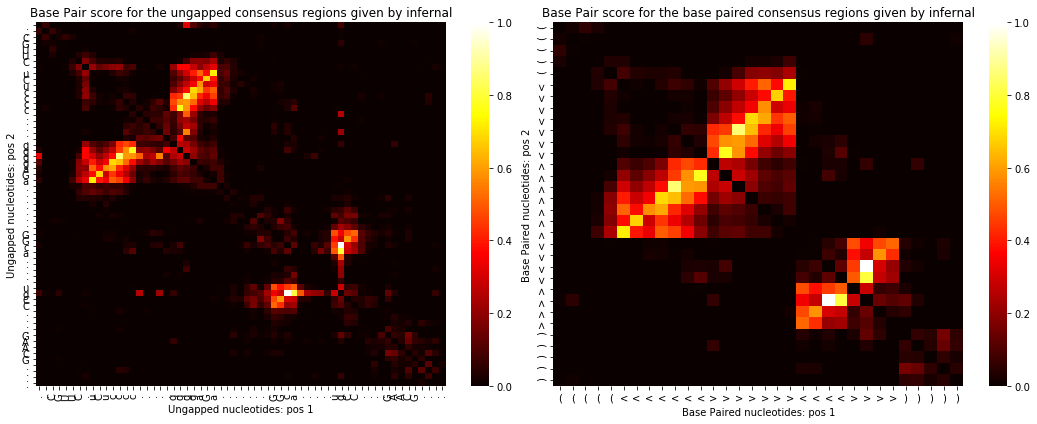

In [328]:
#Let's try something weird
bpfilter = np.ones((4,4))*-1
for i,j in zip(range(4), range(4)):
    bpfilter[i, -(j+1)] = 1.
    
#C = np.sum((mean_mut2*bpfilter).reshape(numug,numug,dims*dims), axis=2)
#norm_mean_mut2= mean_mut2 + np.min(mean_mut2)#np.exp(norm_mean_mut2)  #
C = np.sum((norm_mean_mut2*bpfilter).reshape(numug,numug,dims*dims), axis=2)
C = C - np.mean(C)
C = C/np.max(C)

color = 'hot'

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sb.heatmap(C, xticklabels=bpugSQ, yticklabels=bpugSQ, vmin=0., cmap=color , linewidth=0.00)
plt.title('Base Pair score for the ungapped consensus regions given by infernal')
plt.xlabel('Ungapped nucleotides: pos 1')
plt.ylabel('Ungapped nucleotides: pos 2')
plt.subplot(1,2,2)
sb.heatmap(C[bpugidx][:, bpugidx], xticklabels=bpSS, vmin=0., yticklabels=bpSS, cmap=color, linewidth=0.0)
plt.title('Base Pair score for the base paired consensus regions given by infernal')
plt.xlabel('Base Paired nucleotides: pos 1')
plt.ylabel('Base Paired nucleotides: pos 2')
plt.show

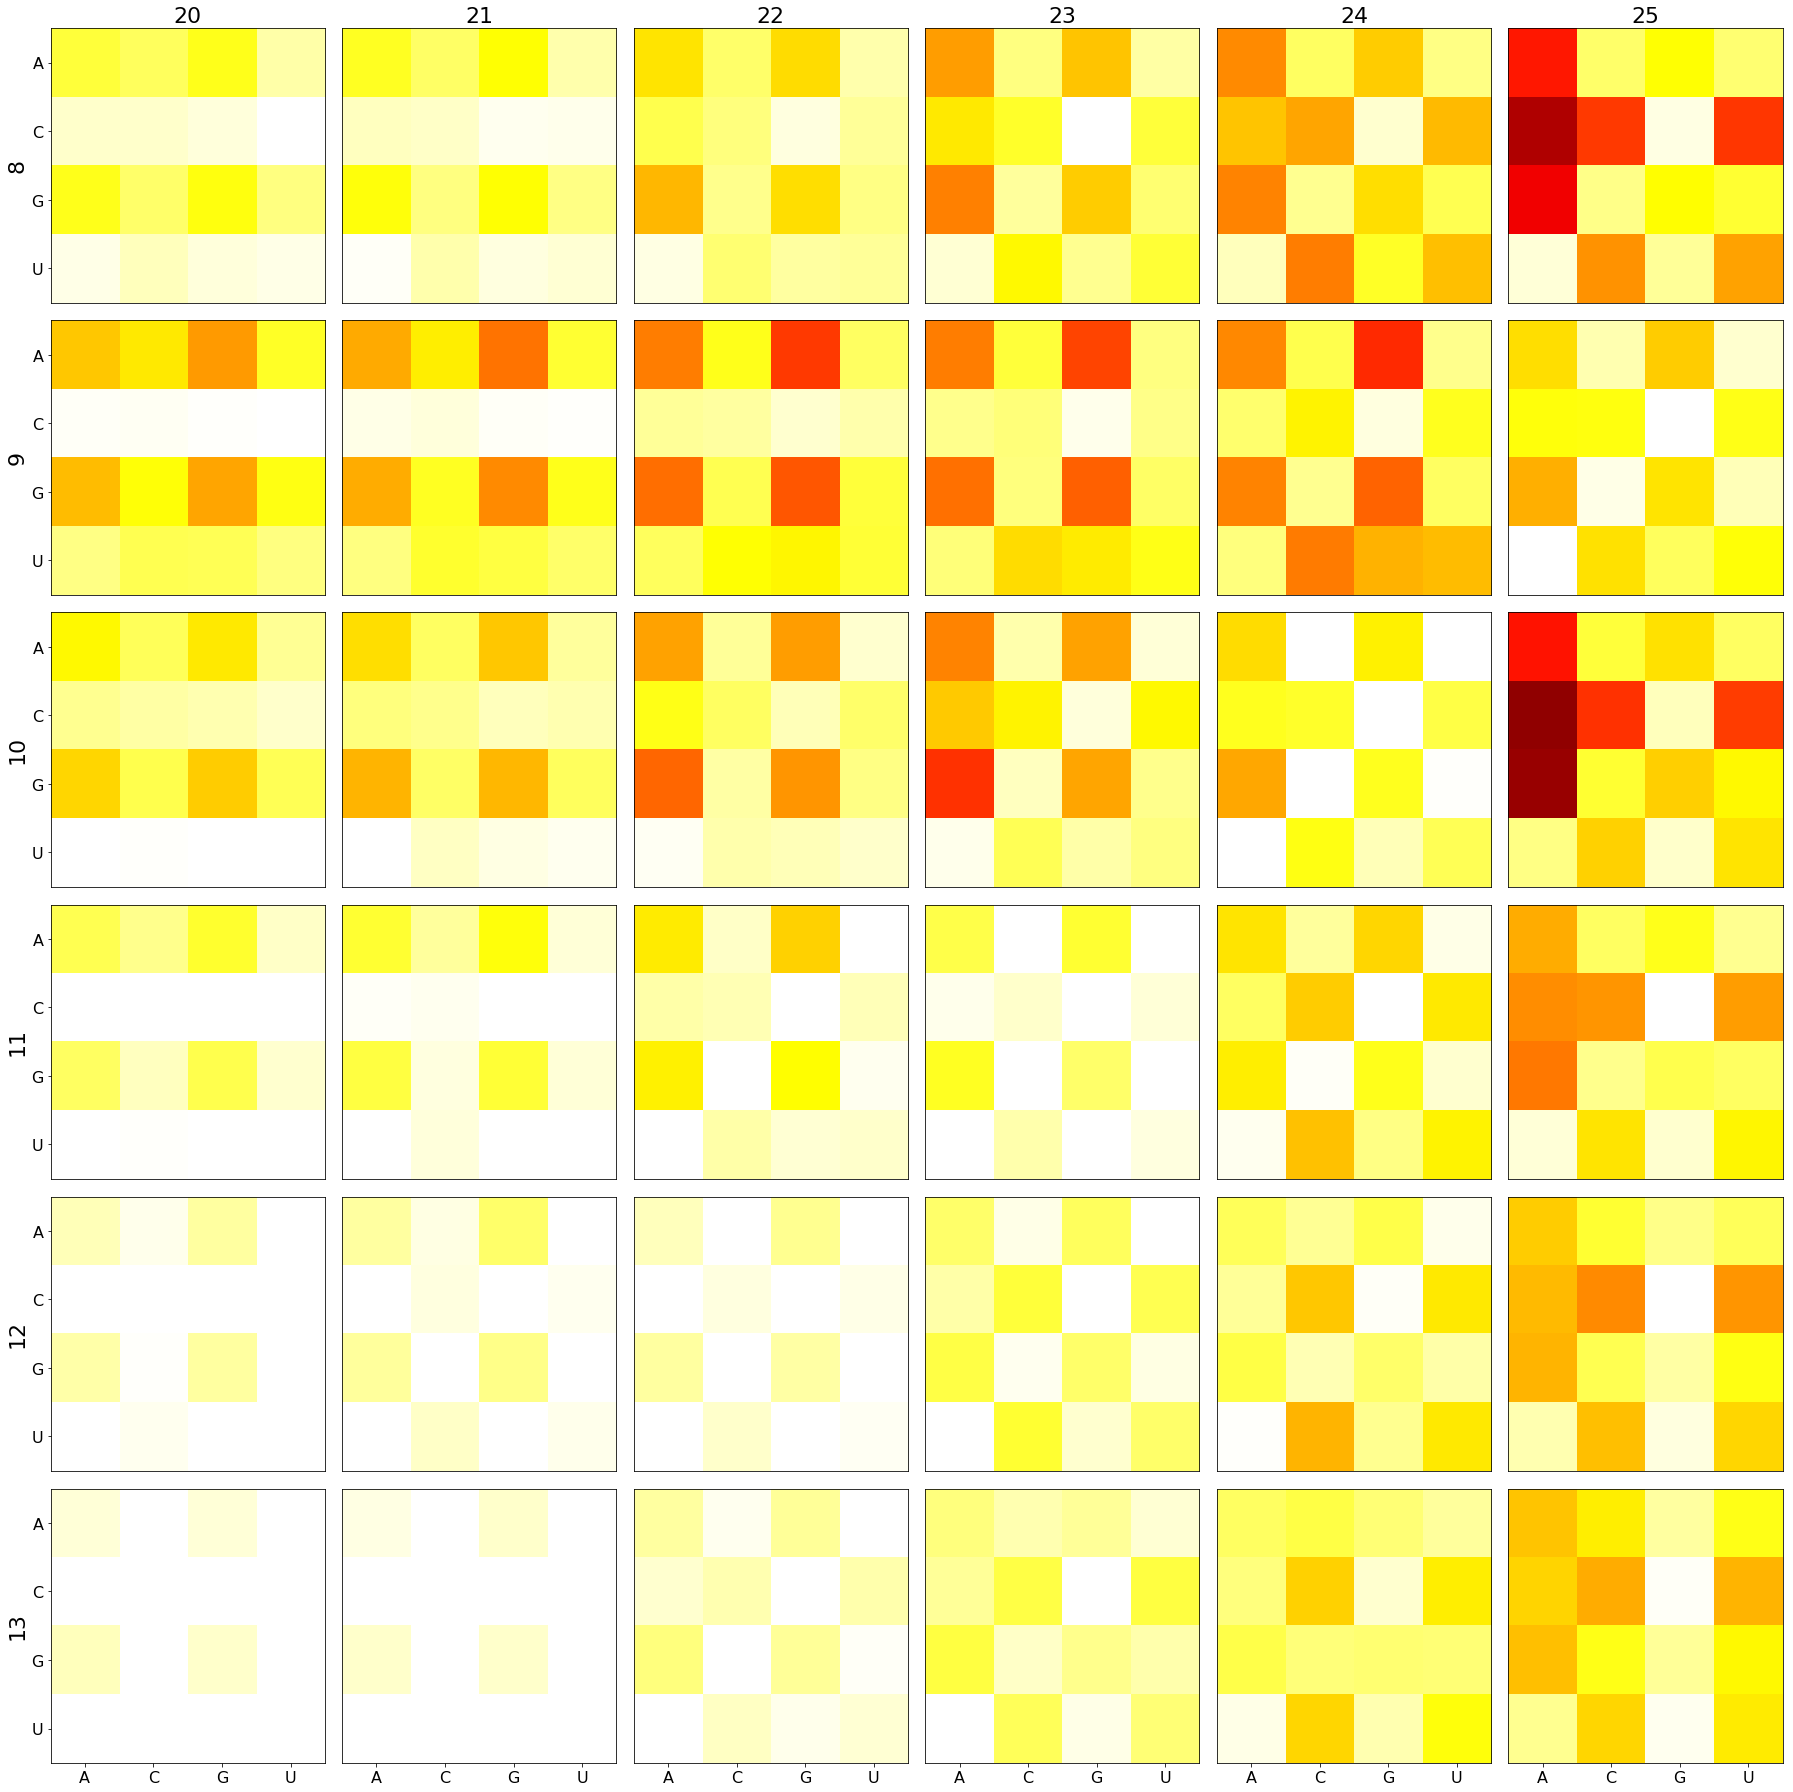

In [228]:
stem1 = bpugidx[5:11]
stem2 = bpugidx[12:18]

fig = plt.figure(figsize=(25,25))
k = 1
for l, i in enumerate(stem1):
    for n, j in enumerate(stem2):
        plt.subplot(len(stem1),len(stem2),k)
        plt.imshow(mean_mut2[i, j, :, :], interpolation='none', cmap='hot', vmax=0., vmin=np.log(0.75))
        
        if k in range(1,len(stem1)**2, len(stem1)):
            plt.yticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=16)
            plt.ylabel(str(i), fontsize=22)
        else:
            plt.yticks([])
        if k in range(len(stem1)**2-len(stem1)+1,len(stem1)**2+1):
            plt.xticks([0, 1, 2, 3], ['A', 'C', 'G', 'U'], fontsize=16)
        else:
            plt.xticks([])

        if k in range(1,len(stem1)+1):
            plt.title(str(j), fontsize=22)
        k += 1


In [370]:
blocklen = np.sqrt(np.product(mean_mut2.shape)).astype(int)
S = np.zeros((blocklen, blocklen))
i,j,k,l = mean_mut2.shape

for ii in range(i):
    for jj in range(j):
        for kk in range(k):
            for ll in range(l):
                S[(4*ii)+kk, (4*jj)+ll] = mean_mut2[ii,jj,kk,ll]

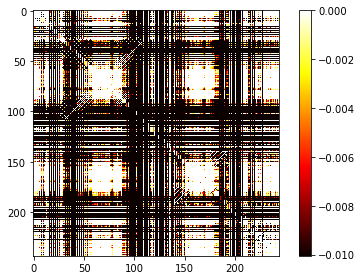

In [372]:
plt.imshow(S, vmax=0., vmin=np.log(0.99), cmap='hot')
plt.colorbar()

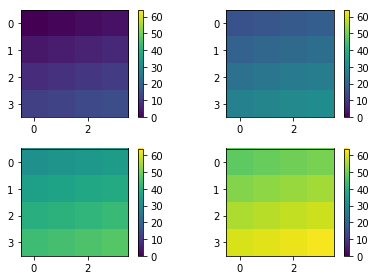

In [344]:
k=1
for l in range(2):
    for m in range(2):
        plt.subplot(2,2,k)
        plt.imshow(U[l,m], vmin=0, vmax=64)
        plt.colorbar()
        k+=1

In [349]:
S = np.zeros((8,8))
for i in range(2):
    for j in range(2):
        for k in range(4):
            for l in range(4):
                S[(4*i)+k, (4*j)+l] = U[i,j,k,l]

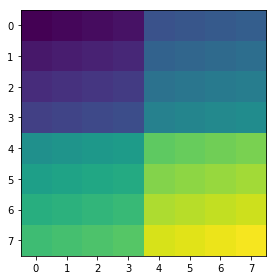

In [350]:
plt.imshow(S, vmin=0, vmax=64)